In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('online_retail_ii.xlsx')

In [26]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [27]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


#### Data Definitions

The data are available from UCI's Machine Learning library: https://archive.ics.uci.edu/ml/datasets/Online+Retail+IIt. From there we have the provided data definitions:

* InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.

* Description: Product (item) name. Nominal.

* Quantity: The quantities of each product (item) per transaction. Numeric.

* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.

* UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).

* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.

* Country: Country name. Nominal. The name of the country where a customer resides.



#### Data Types

In [18]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

Based on what we know about the data, we can predict a few steps in our data processing.
* The 'Invoice' column is filled with 'object' type. We know that some invoices indicating cancellations begin with a 'c', and we also know that the number of the invoice is not as important as the invoice as a grouping function for items purchased by a single customer in a single transaction.
* The 'StockCode' column is also object type. Similar to the 'Invoice' column, we don't want the stock codes themselves per se - but the indication of specific objects purchased, the frequency of purchase, and how often specific customers may purhcase them.
* On first glance, the 'Description' column feels extraneous. It may be useful for further analysis once we identify which items by StockCode are the most frequently purchased, but for now we can remove it.
* The 'InvoiceDate' column is already in datetime format, which will be useful in engineering features we believe will be helpful in our analysis (e.g., time elapsed between transactions, mean time between purchases for specific customers). 
* 'Customer ID' as a float is interesting. Our assumption again is that the number recorded here is not as useful as it is as a grouping function. We will likely replace these.

#### Unique Values and Missing Values

In [19]:
df.nunique()

Invoice        28816
StockCode       4632
Description     4681
Quantity         825
InvoiceDate    25296
Price           1606
Customer ID     4383
Country           40
dtype: int64

There are a few salient points to pull out from the number of unique values.

* 28816 unique Invoice values means that we have 28816 specific transactions to work with. With 4383 unique customers, that means we have an average of 6.7ish transactions per customer.
* The same ratio of invoice values to StockCode values means that we have a good range of items on a per transaction basis.

In [28]:
for col in df.columns:
    print('Column ' + col + ' is missing %.0f values, or %.2f percent.' % (df[col].isnull().sum(),(df[col].isnull().sum()/len(df[col]))*100))

Column Invoice is missing 0 values, or 0.00 percent.
Column StockCode is missing 0 values, or 0.00 percent.
Column Description is missing 2928 values, or 0.56 percent.
Column Quantity is missing 0 values, or 0.00 percent.
Column InvoiceDate is missing 0 values, or 0.00 percent.
Column Price is missing 0 values, or 0.00 percent.
Column Customer ID is missing 107927 values, or 20.54 percent.
Column Country is missing 0 values, or 0.00 percent.


At first glance, it is a bit concerning that we are missing 20.54% of our customer ID values. Based on the data available we will not be able to impute this value - meaning we're losing a fifth of our customer data. But with 4383 unique customers we feel confident that we can still perform a robust analysis. 

Our only other missing values are in Description, which does not concern us for the reasons outlined above.

It may not be missing values, but we know that some rows indicate cancellations, as shown by a 'C' at the beginning of the invoice code.

In [32]:
df.loc[df['Invoice'].str[0] == 'C']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


So 10206 of our 525460 rows indicate cancellations. Not bad in terms of our overall data, but it may be too small for us to pull out any parallel analyses of patterns in the cancellations.

#### Data Ranges

We only have a few numeric columns for which data ranges interest us - price and quantity. So we'll use the describe method to explore those.

In [29]:
df[['Price','Quantity']].describe()

,Price,Quantity
count,525461.000000,525461.000000
mean,4.688834,10.337667
std,146.126914,107.424110
min,-53594.360000,-9600.000000
25%,1.250000,1.000000
50%,2.100000,3.000000
75%,4.210000,10.000000
max,25111.090000,19152.000000


These data are interesting. We know that some of our invoices represent cancellations (see above), so a possible intuition is that a negative price and/or quantity correlates with a cancellation. We'll explore that in our EDA. We can also see that the majority of our prices and quantities fall into a "reasonable" range (the IQR for both staying between 1-10) with some major outliers. We'll have to account for that in our analysis.

#### Other Quick Analyses

There are a few other counts that would be interesting - for example, the distribution of customers by number of purchases. Those are represented below.

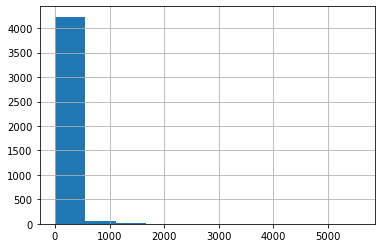

In [38]:
df['Customer ID'].loc[df['Invoice'].str[0] != 'C'].value_counts().hist()

In [40]:
df['Customer ID'].loc[df['Invoice'].str[0] != 'C'].value_counts().head(40)

14911.0    5570
17841.0    5043
14606.0    3866
14156.0    2648
12748.0    2634
17850.0    2499
16549.0    2269
15311.0    2055
14646.0    1774
14527.0    1729
16782.0    1693
13089.0    1545
17377.0    1358
15005.0    1335
13081.0    1330
15039.0    1290
14298.0    1227
15768.0    1211
13564.0    1188
17448.0    1117
17920.0    1107
17589.0    1090
14680.0    1034
13694.0     957
17511.0     948
15998.0     930
13093.0     891
15719.0     843
12681.0     827
13174.0     818
12921.0     814
17085.0     810
14505.0     809
14081.0     789
14667.0     789
15555.0     782
13137.0     737
17243.0     734
17068.0     728
13230.0     728
Name: Customer ID, dtype: int64

In [45]:
(df['Customer ID'].loc[df['Invoice'].str[0] != 'C'].value_counts() == 1).sum()

93

These data show a few things: Our data does have a long right tail, with a few customers driving a significant number of transactions. While the top 40 customers show a pretty wide range in number of purchases (note the loc indexer is removing 'cancellations'). We also know that there are only 93 customers out of 4383 who have made only one purchase, which gives us more confidence that we can do a repeat customer analysis with this dataset.

#### Preparing the Data

Based on the above, we think our only move for data processing will be removing purchases with no customer ID. But we should do some analysis on those transactions to make sure we aren't overindexing on returns or other non-sale transactions.

In [48]:
df.loc[df['Customer ID'].isnull()].describe()

,Quantity,Price,Customer ID
count,107927.000000,107927.000000,0.0
mean,0.971045,7.788750,NaN
std,128.207415,290.474071,NaN
min,-9600.000000,-53594.360000,NaN
25%,1.000000,1.660000,NaN
50%,1.000000,3.360000,NaN
75%,2.000000,5.910000,NaN
max,10200.000000,25111.090000,NaN


In [50]:
df.loc[df['Customer ID'].isnull()].loc[df['Invoice'].str[0] == 'C']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
5897,C489859,M,Manual,-1,2009-12-02 14:45:00,69.57,NaN,United Kingdom
5898,C489860,90029,NEW BAROQUE SMALL NECKLACE BLACK,-1,2009-12-02 14:49:00,8.50,NaN,United Kingdom
6376,C489881,21102,"CANDLE IN JAR COLLAGE , VANILLA",-31,2009-12-02 16:20:00,2.55,NaN,Nigeria
6377,C489881,72802A,ROSE SCENT CANDLE IN JEWELLED BOX,-16,2009-12-02 16:20:00,4.25,NaN,Nigeria
11553,C490307,POST,POSTAGE,-1,2009-12-04 14:49:00,8.97,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
517953,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
519170,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NaN,United Kingdom
519251,C537647,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:41:00,5519.25,NaN,United Kingdom
519294,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom


At a quick glance, it doesn't look like we're throwing away useful data by removing transactions missing a customer ID. We'll remove them and move on to the next step.

In [55]:
df['Customer ID'].dropna(inplace=True)

In [ ]:
df.to_excel('online_retail_adj.xlsx')